In [1]:
!pip install tensorflow-addons
!pip install transformers
!pip install shap

     |████████████████████████████████| 1.1 MB 8.2 MB/s 
     |████████████████████████████████| 4.0 MB 7.8 MB/s 
     |████████████████████████████████| 6.5 MB 25.6 MB/s 
     |████████████████████████████████| 895 kB 50.8 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 564 kB 8.8 MB/s 


In [2]:
# Carga de librerías y Datos

import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import datetime, os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.probability import FreqDist
from sklearn.preprocessing import LabelBinarizer
from sklearn import feature_extraction,model_selection, preprocessing,feature_selection,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,classification_report,precision_recall_curve,auc
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
from scipy import sparse
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import activations
from transformers import TFBertModel, BertConfig,BertTokenizer
nltk.download('stopwords')
nltk.download('wordnet')

# Comprobar disponibilidad de GPU
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

#Cargar los datos
data_train = pd.read_csv('webis_train.csv')
data_train = data_train[['postText','truthClass']]
data_train['postText'] = data_train['postText'].astype('str')
data_test = pd.read_csv('webis_test.csv')
data_test = data_test[['postText','truthClass']]
data_test['postText'] = data_test['postText'].astype('str')

# Comprobar primero si falta algún valor

conteo = data_train.isnull().sum().sum()
print ('Numero de NaN en train: ' + str(conteo))
conteo = data_test.isnull().sum().sum()
print ('Numero de NaN en test: ' + str(conteo))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
1
Numero de NaN en train: 0
Numero de NaN en test: 0


# **Parte 1: EDA y Feature Engineering**

En esta sección se explorarán los datos y se crearán variables que puedan ser útiles para los modelos. Primero hay que comprobar que los datos están balanceados, si no lo están esto afecta al entrenamiento ya que estará sesgado en favor de la calse mayoritaria

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


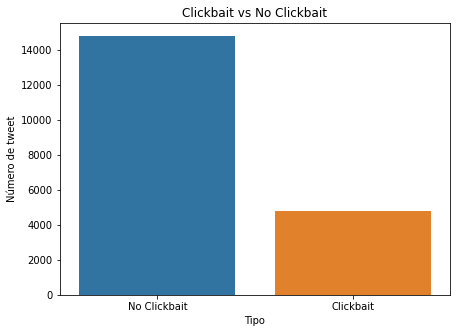

no-clickbait    14777
clickbait        4761
Name: truthClass, dtype: int64

In [3]:
# bar plot
fig  = plt.figure(figsize=(7,5))
fig=sns.countplot(data_train['truthClass'])
plt.title('Clickbait vs No Clickbait')
plt.ylabel('Número de tweet')
plt.xlabel('Tipo')
fig.set(xticklabels=['No Clickbait','Clickbait'])
plt.show()

data_train['truthClass'].value_counts()


Se aprecia aclaramente que están desbalanceados hay 4761 clickbait por 14777 no clickbait. Esto hay que tenerlo en cuenta de cara al entrenamiento.Voy a contar ahora el número de palabras que hay en cada tipo de tweet y añadirla como variable al dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


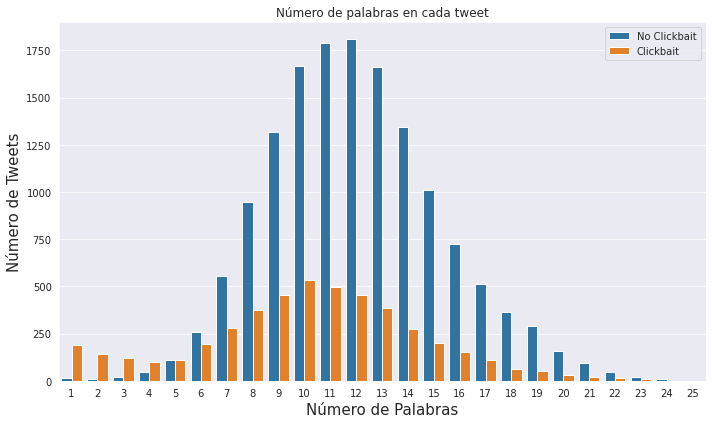

truthClass
clickbait       10.117622
no-clickbait    12.077147
Name: num_palabras, dtype: float64

In [4]:
 
data_train['num_palabras'] = data_train['postText'].apply(lambda x: len(x.split()))

#plot
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(data_train['num_palabras'],hue=data_train['truthClass'],data=data_train)
plt.xlabel('Número de Palabras',size=15)
plt.ylabel('Número de Tweets', size=15)
plt.legend(title=None,labels=['No Clickbait','Clickbait'],loc='upper right')
plt.title('Número de palabras en cada tweet')
plt.tight_layout()
plt.show()

# Contar la media de palabras que tiene un tweet por cada clase
data_train.groupby('truthClass')['num_palabras'].mean()

LLama la atención de que a pesar de que hay menos tweets de clickbait, son los que hay más con 1,2,3 o 4 palabras con un gran margen. También se observa que los tweets que son clickbait tienen de media pocas palabras. Voy a contar a continuación si el tweet tiene una pregunta o no y añadirla como variable

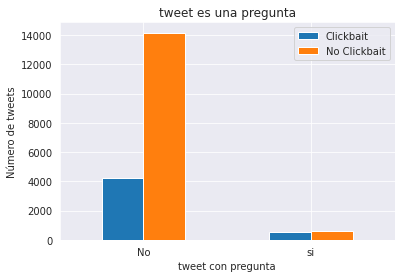

El porcentaje de tweets clickbaits que son preguntas es del : 11.76 %
El porcentaje de tweets No clickbaits que son preguntas es del : 4.20 %


In [5]:

def es_pregunta(texto):

  ''' Función que tiene como input un texto y devuelve 1 o 0 en función de si el texto e suna pregunta o no'''

  if "?" in texto or texto.startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','did','do')):
      return 1
  else: 
      return 0

data_train['pregunta'] = data_train['postText'].apply(es_pregunta)

pregunta = data_train.groupby('pregunta')['truthClass'].value_counts().unstack()

#plot
sns.set_style('darkgrid')
plot = pregunta.plot.bar(rot = 0)
plot.set_xlabel('tweet con pregunta')
plot.set_ylabel('Número de tweets')
plot.legend(title=None,labels=['Clickbait','No Clickbait'],loc='upper right')
plot.set(xticklabels=['No','si'])
plot.set_title('tweet es una pregunta')
plt.show()

# para sacar porcentajes de tweets con preguntas
porcentaje_clickbait = (pregunta['clickbait'][1]/pregunta['clickbait'].sum())*100
porcentaje_no_clickbait = (pregunta['no-clickbait'][1]/pregunta['no-clickbait'].sum())*100

print('El porcentaje de tweets clickbaits que son preguntas es del : {:02.2f} %'.format(porcentaje_clickbait))
print('El porcentaje de tweets No clickbaits que son preguntas es del : {:02.2f} %'.format(porcentaje_no_clickbait))


Parece que hay un mayor porcentaje de tweets clickbait con pregunta . A continuación voy a hacer lo mismo pero para ver tweets con !, y añadir esta variable al dataset

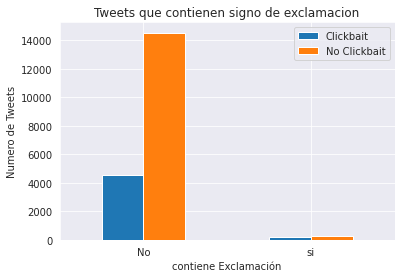

El porcentaje de tweets clickbaits que tienen exclamacion es del : 4.16 %
El porcentaje de tweets No clickbaits que tienen exclamacion es del : 1.66 %


In [6]:

def tiene_exclamacion(texto):

    '''Función que tiene como input un texto y devuelve 0,1 en función de si contiene una exclamación o no'''

    if "!" in texto: 
      return 1
    else: 
      return 0

data_train['exclamacion']=data_train['postText'].apply(tiene_exclamacion)
exclamacion = data_train.groupby('exclamacion')['truthClass'].value_counts().unstack()

#plot
sns.set_style('darkgrid')
plot = exclamacion.plot.bar(rot = 0)
plot.set_xlabel('contiene Exclamación')
plot.set_ylabel('Numero de Tweets')
plot.legend(title=None,labels=['Clickbait','No Clickbait'])
plot.set(xticklabels=['No','si'])
plot.set_title('Tweets que contienen signo de exclamacion')
plt.show()

# para sacar porcentajes de tweets con exclamación
porcentaje_clickbait = (exclamacion['clickbait'][1]/exclamacion['clickbait'].sum())*100
porcentaje_no_clickbait = (exclamacion['no-clickbait'][1]/exclamacion['no-clickbait'].sum())*100

print('El porcentaje de tweets clickbaits que tienen exclamacion es del : {:02.2f} %'.format(porcentaje_clickbait))
print('El porcentaje de tweets No clickbaits que tienen exclamacion es del : {:02.2f} %'.format(porcentaje_no_clickbait))

Parecer que los tweet con clickbaits aparecen más signos de exclamación. A continuación voy a hacer lo mismo para ver que porcentaje de tweets empiezan con número y añadirlo como variable

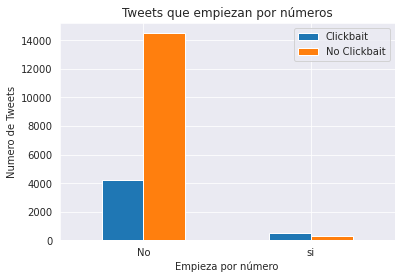

El porcentaje de tweets clickbaits que empiezan por número es del : 10.71 %
El porcentaje de tweets No clickbaits que empiezan por número es del : 1.89 %


In [7]:

def empieza_con_numero(texto):

    ''' Función que devuelve si un tweet empieza por número o no'''
    if texto.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

data_train['empieza_con_numero'] = data_train['postText'].apply(empieza_con_numero)
numero = data_train.groupby('empieza_con_numero')['truthClass'].value_counts().unstack()


#plot
sns.set_style('darkgrid')
plot = numero.plot.bar(rot = 0)
plot.set_xlabel('Empieza por número')
plot.set_ylabel('Numero de Tweets')
plot.legend(title=None,labels=['Clickbait','No Clickbait'])
plot.set(xticklabels=['No','si'])
plot.set_title('Tweets que empiezan por números')
plt.show()

# para sacar porcentajes de tweets con exclamación
porcentaje_clickbait = (numero['clickbait'][1]/numero['clickbait'].sum())*100
porcentaje_no_clickbait = (numero['no-clickbait'][1]/numero['no-clickbait'].sum())*100

print('El porcentaje de tweets clickbaits que empiezan por número es del : {:02.2f} %'.format(porcentaje_clickbait))
print('El porcentaje de tweets No clickbaits que empiezan por número es del : {:02.2f} %'.format(porcentaje_no_clickbait))


Parece que hay bastante diferencia de porcentaje que empiezan por número. A continuación voy a sacar los porcentajes de tweets con hashtags y que mencionan y añadirlos como variable

In [8]:
#Primero para el Hashtag

def tiene_hashtag(texto):

    '''Función que tiene como input un texto y devuelve 0,1 en función de si contiene una # o no'''

    if "#" in texto: 
      return 1
    else: 
      return 0

data_train['hashtag'] = data_train['postText'].apply(tiene_hashtag)
hashtag = data_train.groupby('hashtag')['truthClass'].value_counts().unstack()

porcentaje_clickbait = (hashtag['clickbait'][1]/hashtag['clickbait'].sum())*100
porcentaje_no_clickbait = (hashtag['no-clickbait'][1]/hashtag['no-clickbait'].sum())*100

print('El porcentaje de tweets clickbaits que tiene hashtag es del : {:02.2f} %'.format(porcentaje_clickbait))
print('El porcentaje de tweets No clickbaits que tiene hashtag es del : {:02.2f} %'.format(porcentaje_no_clickbait))

#Para menciones

def tiene_mencion(texto):

    '''Función que tiene como input un texto y devuelve 0,1 en función de si contiene una @ o no'''

    if "@" in texto: 
      return 1
    else: 
      return 0

data_train['mencion'] = data_train['postText'].apply(tiene_mencion)
mencion = data_train.groupby('mencion')['truthClass'].value_counts().unstack()

porcentaje_clickbait = (mencion['clickbait'][1]/mencion['clickbait'].sum())*100
porcentaje_no_clickbait = (mencion['no-clickbait'][1]/mencion['no-clickbait'].sum())*100

print('El porcentaje de tweets clickbaits que tiene mencion es del : {:02.2f} %'.format(porcentaje_clickbait))
print('El porcentaje de tweets No clickbaits que tiene mencion es del : {:02.2f} %'.format(porcentaje_no_clickbait))



El porcentaje de tweets clickbaits que tiene hashtag es del : 8.82 %
El porcentaje de tweets No clickbaits que tiene hashtag es del : 11.13 %
El porcentaje de tweets clickbaits que tiene mencion es del : 5.27 %
El porcentaje de tweets No clickbaits que tiene mencion es del : 10.27 %


En este caso parece que los tweets no clickbait tienen más menciones y hashtag. Después de estas features engineering el dataset queda compuesto de la siguiente manera:

In [9]:
data_train.head(10)

,postText,truthClass,num_palabras,pregunta,exclamacion,empieza_con_numero,hashtag,mencion
0,UK’s response to modern slavery leaving victim...,no-clickbait,12,0,0,0,0,0
1,this is good,clickbait,3,0,0,0,0,0
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,15,0,0,0,0,0
3,Meet the happiest #dog in the world!,clickbait,7,0,1,0,1,0
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,16,0,0,0,0,0
5,Ban lifted on Madrid doping laboratory,no-clickbait,6,0,0,0,0,0
6,"Despite the ‘Yuck Factor,’ Leeches Are Big in ...",no-clickbait,10,0,0,0,0,0
7,#China and #Pakistan have cemented their polit...,no-clickbait,13,0,0,0,1,0
8,"Malls are dying, but it's hard to profit from ...",no-clickbait,13,0,0,0,0,1
9,Filipino troops kill notorious Abu Sayyaf kidn...,no-clickbait,9,0,0,0,0,0


Transformar labels y comprobar correlación entre variables. Si hubiera correlación entre las nuevas variables se podría descartar una de ellas.

In [10]:
# Primero voy a transformar las labels a dummy variables

lb = LabelBinarizer()

data_train = data_train.join(pd.DataFrame(lb.fit_transform(data_train['truthClass']),columns = ['Clase'])).drop(['truthClass'],axis = 1)

featured_made = data_train.drop('postText', axis = 1)

featured_made.corr()

,num_palabras,pregunta,exclamacion,empieza_con_numero,hashtag,mencion,Clase
num_palabras,1.000000,0.016495,-0.031655,-0.046915,0.040023,0.041949,0.227876
pregunta,0.016495,1.000000,0.017567,-0.038912,0.030997,0.011352,-0.136359
exclamacion,-0.031655,0.017567,1.000000,-0.015580,0.152067,0.069178,-0.071847
empieza_con_numero,-0.046915,-0.038912,-0.015580,1.000000,-0.039206,-0.034826,-0.192433
hashtag,0.040023,0.030997,0.152067,-0.039206,1.000000,0.128892,0.032175
mencion,0.041949,0.011352,0.069178,-0.034826,0.128892,1.000000,0.074813
Clase,0.227876,-0.136359,-0.071847,-0.192433,0.032175,0.074813,1.000000


Las nuevas variables generadas parecen no estar correlacionadas entre ellas en gran medida, siendo la variable número de palabras la que está más correlacionada con el target

**Data transformation y más visualizaciones**

Para que los modelos de NLP basados en técnicas clásicas de machine learning tengan mayor rendimiento es necesario hacer una serie de transformaciones a los inputs, no puede haber strings, y siempre es conveniente quitar palabras comunes y signos de puntuación entre otros pre procesamientos con el objetivo de simplicar el texto y hacer que al vectorizar el texto la matrix resultante sea un poco más manejable y no tan sparse, Esto se puede hacer porque estos modelos no tienen información contextual. También sacaré más visualizaciones en lo referente a palabras más comunes en cada grupo

In [11]:


# A continuación voy a procesar el texto para limpiarlo de elementos que no aportan valor y simplificarlo


def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    '''
    Esta función tiene como input una string y la duelve limpia. Se puede usar con los siguientes parametros:

        text: string - texto
        lst_stopwords: list - lista de stopswords
        flg_stemm: bool - aplicar stemming
        flg_lemm: bool - aplicar lemmatisation

    '''

    ## convertir a lowercase y quitar puntuación
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenizar 
    lst_text = text.split()

    ## quitar Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (quitar -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (pasar la palabra a la raíz)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## pasar de lista a string
    text = " ".join(lst_text)
    return text




In [12]:
list_stopwords = nltk.corpus.stopwords.words("english")

data_train['texto_limpio'] = data_train['postText'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

text_train = data_train[['postText','Clase']]
data_train.drop(['postText'],axis = 1, inplace=True)

data_train.head()

,num_palabras,pregunta,exclamacion,empieza_con_numero,hashtag,mencion,Clase,texto_limpio
0,12,0,0,0,0,0,1,uk response modern slavery leaving victim dest...
1,3,0,0,0,0,0,0,good
2,15,0,0,0,0,0,1,forgotten trump roast relive brutal 2004 thras...
3,7,0,1,0,1,0,0,meet happiest dog world
4,16,0,0,0,0,0,1,tokyo subway shut amid fear imminent north kor...


Para finalizar con el EDA y la parte de feature engineering voy a calcular las palabras más comunes en cada clase y mostrarlas en un gráfico.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


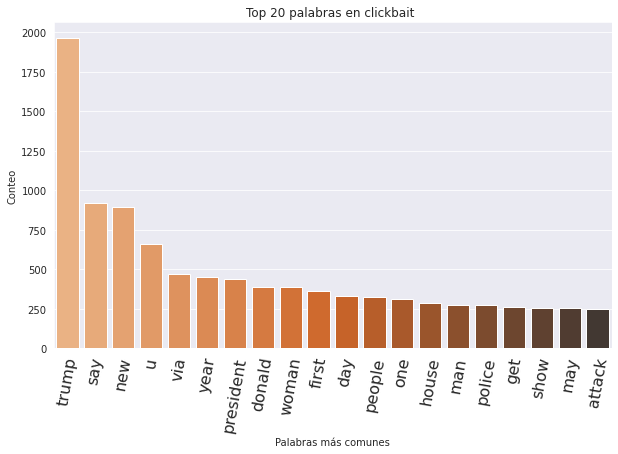

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


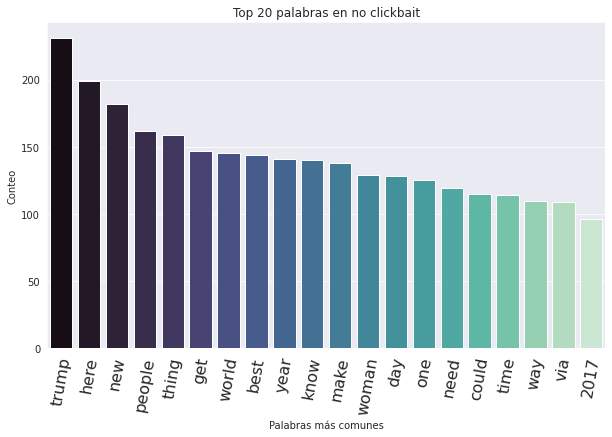

In [13]:
# Primero voy a crear dos dataframes diferenciados por clase


df_cb=data_train[data_train['Clase']==1]
df_ncb=data_train[data_train['Clase']==0]

#Ahora crearé una lista de palabras unicas por clase

cb_list=list(df_cb['texto_limpio'])
cb_list = [wrd for sub in cb_list for wrd in sub.split()]
ncb_list=list(df_ncb['texto_limpio'])
ncb_list = [wrd for sub in ncb_list for wrd in sub.split()]

# El siguiente código es para sacar las frecuencias de las palabras
cb_freq = FreqDist(cb_list)
ncb_freq = FreqDist(ncb_list)

cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]

ncb_bar_counts = [x[1] for x in ncb_freq.most_common(20)]
ncb_bar_words = [x[0] for x in ncb_freq.most_common(20)]


#plots con las 20 palabras más comunes en cada clase
#clickbait
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 palabras en clickbait ')
plt.xlabel('Palabras más comunes')
plt.ylabel('Conteo')
sns.set_style('darkgrid')
plt.show()

#no clickbait
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(ncb_bar_words, ncb_bar_counts,palette='mako')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 palabras en no clickbait')
plt.xlabel('Palabras más comunes')
plt.ylabel('Conteo')
plt.show()



Parece ser que trump es la palabra más popular pero hay mucha más diferencia en el de clickbait alrededor del 40 % de tweets que son clickbaits tienen la palabra trump, lo que es algo muy significativo, además ente el top 20 también están president y donald, con lo que muchos tweets de clickbait tienen que ver con el presidente de EEUU en aquel momento.




In [14]:
# Preparar el datasets de test con el mismo pre procesamiento que el de train

data_test['num_palabras'] = data_test['postText'].apply(lambda x: len(x.split()))
data_test['pregunta'] = data_test['postText'].apply(es_pregunta)
data_test['exclamacion']=data_test['postText'].apply(tiene_exclamacion)
data_test['empieza_con_numero'] = data_test['postText'].apply(empieza_con_numero)
data_test['hashtag'] = data_test['postText'].apply(tiene_hashtag)
data_test['mencion'] = data_test['postText'].apply(tiene_mencion)
data_test['texto_limpio'] = data_test['postText'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

data_test = data_test.join(pd.DataFrame(lb.fit_transform(data_test['truthClass']),columns = ['Clase'])).drop(['truthClass'],axis = 1)

text_test = data_test[['postText','Clase']]
data_test.drop(['postText'],axis = 1, inplace=True)

y_train = data_train['Clase'].values
y_test = data_test['Clase'].values

clases = ['Clickbait','No Clickbait']
y_test_array = pd.get_dummies(y_test, drop_first=False).values



Antes de empezar con el modelo voy definir las funciones que voy a utilizar para sacar las métricas de los resultados...

In [15]:
## Accuracy, Precision, Recall,f1

def metricas(y_test,pred):

  accuracy = accuracy_score(y_test, pred)

  return print("Accuracy:",  round(accuracy,2)) , print(classification_report(y_test, pred))
  
## Plot confusion matrix

def conf_matrix(y_test, pred):

  cm = confusion_matrix(y_test, pred)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=clases, 
        yticklabels=clases, title="Confusion matrix")
  plt.yticks(rotation=0)

 
    
## Plot precision-recall curve

def pr_curve(y_test_array,predicted_prob):
  fig, ax = plt.subplots(nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(clases)):
      fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(clases[i], 
                                auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="ROC")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(clases)):
      precision, recall, thresholds = precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(clases[i], 
                                    auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

# **Parte 2 modelo de machine learning**

Una vez que hemos creado las nuevas variables hace falta vectorizar el texto para que sea ingestable para los modelos. Para vectorizar y crear el vocabulario voy a utilizar Tf-Idf es una forma de vectorizar un poco más sofisticada que simplemente contar palabras, y basicamente consiste en que el valor de la palabra se incrementa proporcionalmente con el conteo pero es inversamente proporcional a la cantidad de veces que esa palabra aparece en todos los tweets. El tf-Idf que voy a usar va atener un vocabulario de 10000 palabras y va a usar n_grams de 2 para capturar bigramas como "new york"

(19538, 10000)

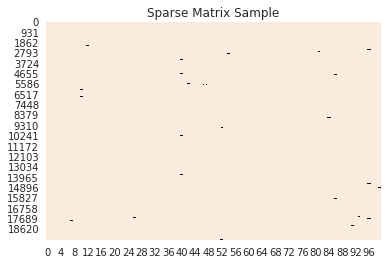

In [16]:
## Tf-Idf 
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))


corpus = data_train['texto_limpio']
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

X_train.shape



La transformación deja una matriz de features bastante sparse. Los valores que no son cero están en negro. Con el objetivo de reducir la dimencionalidad de la matriz y quitar columnas se puede hacer un Chi-square test para conservar solo las variable más relevantes para el target. Conservaré las variables que superen un p value de 0.95.

In [17]:
y = data_train['Clase']
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()


vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
#ahora para el test
corpus_test = data_test['texto_limpio']
vectorizer.fit(corpus_test)
X_test = vectorizer.transform(corpus_test)

data_train_final = data_train.drop(['Clase','texto_limpio'],axis = 1)
data_test_final = data_test.drop(['Clase','texto_limpio'],axis = 1)

X_train.shape


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(19538, 442)

La matriz se ha reducido enormemente ahora solo conserva 442 de las features que son más relevantes estadisticamente. 

In [18]:
# Voy a crear el dataset completo uniendo estas features con las que he creado anteriormente

X_train = sparse.hstack([data_train_final, X_train]).tocsr()
X_test = sparse.hstack([data_test_final, X_test]).tocsr()
print(X_train.shape)
print(X_test.shape)

(19538, 448)
(18979, 448)


**Desarrollo de modelos y métricas**

Primero empezaré con un modelo Dummy para usar como benchmark. Este modelo asigna aleatoriamente el resultado.

En cuanto a las métricas. Dado que es el objetivo es detectar los tweet con clickbait en un dataset la Recall y el f1 son las métricas más importantes, el f1 hay que tenerlo en cuenta para no descuidar la precision. 

El recall nos dice la capacidad del algoritmo de detectar todas las ocurrencias positivas de la variable target en todo el dataset, es decir capacidad de detectar los clickbait que hay en el dataset, Por el contrario la precision del algoritmo te dice de las veces que el algoritmo detecta un clickbait cuantas veces de verdad es un clickbait y no un falso postivo. Finalmente el f1 es una combinación de las dos métricas anteriores. 

También calcularé la curva de la precision-racall para ver el trade off entre los dos y el area bajo la curva. Finalmente calcularé la ROC aunque quizá sea menos indicativa en este problema. 

Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.24      0.50      0.32      4515
           1       0.76      0.50      0.60     14464

    accuracy                           0.50     18979
   macro avg       0.50      0.50      0.46     18979
weighted avg       0.64      0.50      0.53     18979



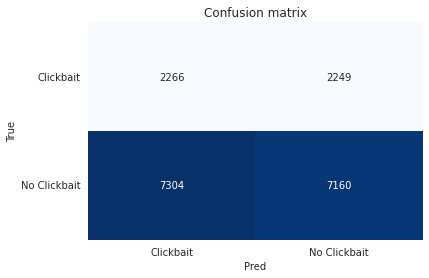

In [19]:
# Clasificador dummy

dc = DummyClassifier(strategy='uniform')

dc.fit(X_train, y_train)

dc_test_preds = dc.predict(X_test)

# Metricas
metricas(y_test,dc_test_preds)
conf_matrix(y_test, dc_test_preds)

El primer algoritmo que voy a probar es el randomforest, es un emsemble y normalmente da buenos resultados en tareas de clasificación con muchas variables.

Para determinar los mejores hiperparametros del modelo haré un gridsearch para encontrar los óptimos. Además esta implementación hace un crossvalidation por lo que ya divide el dataset en uno de validation y train.

Finalmente, para atajar el problema del desbalanceo de clases he optado por dar diferente peso a los errores del modelo en función de como de infrarepresentada es en el dataset esa clase en la que se ha equivocado. Esto tiene una muy fácil implementación en skitlearn solo hay que pasar la variable class_weight como balanced. Esto lo he aplicado en los dos modelos tanto en el RandomForest como en el SVM.

In [20]:

#RandomForest

rfc = RandomForestClassifier()

forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14)), 'class_weight' : ['balanced']}]

clf = model_selection.GridSearchCV(rfc, forest_params, cv = 5, scoring='f1')

clf.fit(X_train, y_train)

print(clf.best_params_)

KeyboardInterrupt: ignored

La combinación de hiperparametros óptima para obtener el mayor recall ha sido la siguiente: 'class_weight': 'balanced', 'max_depth': 13, 'max_features': 12, A continuación entrenare el modelo con estos parametros y obtendré las métricas con el test set

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      4515
           1       0.86      0.87      0.87     14464

    accuracy                           0.80     18979
   macro avg       0.72      0.72      0.72     18979
weighted avg       0.80      0.80      0.80     18979



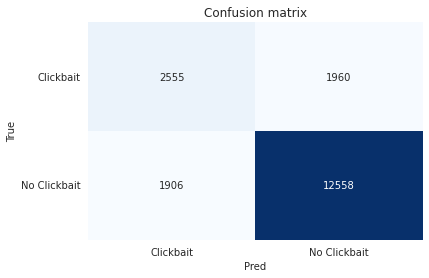

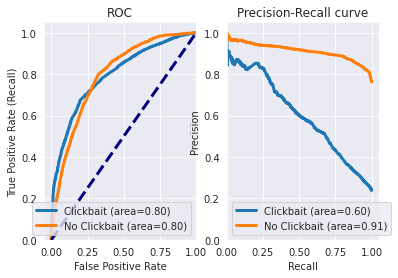

In [51]:
rfc = RandomForestClassifier(class_weight = 'balanced', max_features=12,max_depth=13,n_estimators=1000 )
rfc.fit(X_train, y_train)
rf_test_preds = rfc.predict(X_test)
predicted_prob = rfc.predict_proba(X_test)

# Metricas
metricas(y_test,rf_test_preds)
conf_matrix(y_test, rf_test_preds)
pr_curve(y_test_array,predicted_prob)

Los resultados son mejores que con el modelo dummy, En el f1 es notablemente mejor para la clase clickbait lo que quiere decir que hay un mucho mejor balanceo entre recall y precision. No obstante hay todavía un gran numero de tweet con clickbait que no son detectados un 43%. En la curva precision-recall se muestra que si quisieramos ajustar la recall se penalizaría mucho y rápidamente la precision, esto tiene que ver también con el desbalanceo del dataset.

El siguiente algoritmo que voy a probar un SVM que es un buen clasificador para cuando el espacio de dimonsionalidad es muy alto, como es el caso aqui.

In [19]:
# SVM

svm_clf = svm.SVC()

svm_params = [{'C': [0.1,1,10], 'gamma': [0.1,0.01],'kernel': ['rbf','sigmoid'],'class_weight' : ['balanced']}]

clf = model_selection.GridSearchCV(svm_clf, svm_params, cv = 5, scoring='f1')

clf.fit(X_train, y_train)

print(clf.best_params_)

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}


Los valores óptimos son los siguientes: 'C': 1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      4515
           1       0.85      0.87      0.86     14464

    accuracy                           0.79     18979
   macro avg       0.70      0.70      0.70     18979
weighted avg       0.78      0.79      0.78     18979



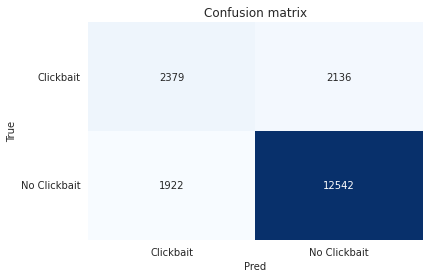

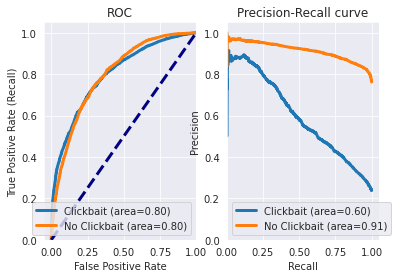

In [52]:
svm_clf = svm.SVC(class_weight='balanced',C=1,gamma = 0.01,kernel = 'rbf',probability=True )
svm_clf.fit(X_train, y_train)
svm_test_preds = svm_clf.predict(X_test)
predicted_prob = svm_clf.predict_proba(X_test)

# Metricas
metricas(y_test,svm_test_preds)
conf_matrix(y_test, svm_test_preds)
pr_curve(y_test_array,predicted_prob)


En este caso 


# **Parte 3: Modelo de Transformer**

Para el siguiente modelo voy a utilizar uno de deep learing, concretamente BERT. Es un modelo que revolucionó en su momento el espacio del NLP. A diferencia de los anteriores los vectores que produce BERT tienen en cuenta el contexto en que la palabra se encuentra y además es capaz de tratar el problema de la ambiguedad de la palabra, El vector que asigna BERT a una palabra va en función de la frase en la que se encuentre, por lo tanto una misma palabra pude tener diferentes vectores dependiendo de donde se encuentre.

Una nota importante y a diferencia de los dos modelos anteriores es que el input de BERT tiene que ser el texto sin procesar, es decir sin quitar stopswords, signos o terminaciones. De esta manera se aprovecha la capacidad para incluir el contexto que tiene BERT.

In [21]:
# Primero es necesario tokenizar el texto en el formato que pide BERT

# divir el set en train y validación
dtf_train, dtf_validation = model_selection.train_test_split(text_train, test_size=0.15)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


def text_processing(tokenizer,texto,batch_size = 256,max_length=30):

  '''
     Esta función tiene como input un batch de texto y devuelve los encondings
     y los attention mask ya listos para ser procesados en un modelo pre entrenado

     Inputs:
     -Tokenizer: El tokenizador que se va a utilizar
     -Texto: El conjunto de textos que se quiere tokenizar, tiene que ser una lista de strings
     -batch_size: Tamaño del batch.
     -max_length: Número máximo de palabras para ser tokenizadas en un texto. 
     
     output:
     - input_ids: secuencia de textos encoded como tensor
     - attention_mask:  las attention mask del texto encoded como tensor
      '''

  input_ids = []
  attention_mask = []

  for i in range(0, len(texto), batch_size):
          batch = texto[i:i+batch_size]
          inputs = tokenizer.batch_encode_plus(batch,
                                              max_length=max_length,
                                              padding='longest',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_token_type_ids=False
                                              )
          input_ids.extend(inputs['input_ids'])
          attention_mask.extend(inputs['attention_mask'])

  return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

X_train = dtf_train['postText']
X_valid = dtf_validation['postText']
X_test = text_test['postText']

y_train = dtf_train['Clase'].values
y_valid = dtf_validation['Clase'].values
y_test = text_test['Clase'].values

# convertir X_train
X_train_id, X_train_attention = text_processing(tokenizer, X_train.tolist())

# convertir X_valid
X_valid_id, X_valid_attention = text_processing(tokenizer, X_valid.tolist())

# convertir X_test
X_test_id, X_test_attention = text_processing(tokenizer, X_test.tolist())




Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Lo siguiente es definir la arquitectura del modelo y elegir algunos hiperparametros.

Como en el caso anterior se ha tenico en cuenta el problema sel desbalanceo de clases y se ha segudio la misma estrategia de penalizar los errores de la clase infrarepresentada. para ello he utilizado una función muy conveniente de skitlearn que calcual el peso proporcialnal de cada clase.

En cuento al learning rate he implementado uno pequeño que va decayendo para reducir la posibilidad de overfitting

El optimizador es un Adam con weight decay que es parecida a una L2 reguralization la idea es que ha sido observado que redes con weight más pequeñas overfitean menos.

Para la arquitectura he cogido el output como dá el BERT pre entrenado y lo he utilizado como input a un clasificador que principalmente son de capas de dense layers con dropout, finalmente hay una activación sigmoid ya que el problema es binario para obtener el resultado.

In [24]:

BATCH_SIZE = 64
NUM_STEPS = len(X_train.index) // BATCH_SIZE
EPOCHS = 5

# Calcular pesos de la clase

class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                                                         classes=np.unique(y_train),
                                                         y=y_train)))

# Voy a implementar un learning rate decay con un AdamW

num_train_steps = len(X_train_id) * EPOCHS
lr_scheduler = PolynomialDecay(
    initial_learning_rate=2e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

opt = tfa.optimizers.AdamW(learning_rate=lr_scheduler,weight_decay=0.01, amsgrad=False)



# Configurar la inizialización de BERT
config = BertConfig(dropout=0.2, 
                          attention_dropout=0.2, 
                          output_hidden_states=True)
                          

BERT = TFBertModel.from_pretrained('bert-base-uncased', config=config)

# Para que la layers no se entrenen y convervar la info
for layer in BERT.layers:
    layer.trainable = False


def build_model(transformer, max_length=30, opt = opt):

    
    # Inizializar los pesos
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42) 
    
    #input layer
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    cls_token = last_hidden_state[:, 0, :]

    #Arquitectura de la cabeza

    D1 = tf.keras.layers.Dropout(0.2,42)(cls_token)

    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(0.2,42)(X)
    
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)
    
    D3 = tf.keras.layers.Dropout(0.2,42)(X)

    
    # output layer
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)
    
    
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compilar
    model.compile(opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    
    
    return model

model = build_model(BERT, max_length=30, opt = opt)



Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:

# Entrenar el modelo
train = model.fit(
    x = [X_train_id, X_train_attention],
    y = y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    class_weight=class_weights,
    validation_data = ([X_valid_id, X_valid_attention], y_valid),
    verbose=3
)



Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.58      0.68      0.63      4515
           1       0.89      0.85      0.87     14464

    accuracy                           0.81     18979
   macro avg       0.74      0.76      0.75     18979
weighted avg       0.82      0.81      0.81     18979



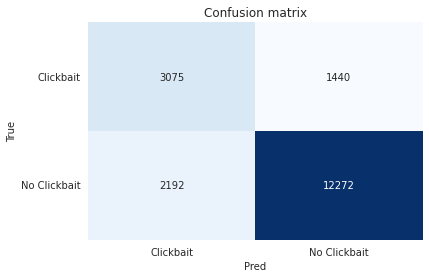

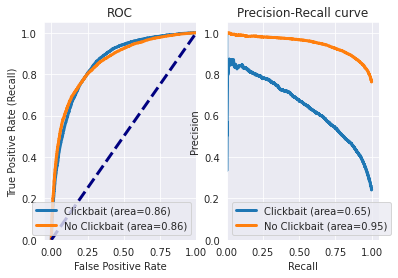

In [33]:
#Predicción
y_pred = model.predict([X_test_id, X_test_attention])
y_pred_clase = np.where(y_pred >= 0.5, 1, 0)

#Métricas
metricas(y_test,y_pred_clase)
conf_matrix(y_test, y_pred_clase)

## calcular ndarry para precion-recall curve input
probs = []
for i in y_pred:
  prob = 1 - i
  probs.append(prob)

probs = np.asarray(probs, dtype=np.float32)
y_pred_p = np.append(probs, y_pred, axis = 1)
pr_curve(y_test_array,y_pred_p)


Los resultados que arroja este modelo son, como es esperado, superiores a los anteriores aunque todavía quedan muchos clickbait clasificados erroneamente el 32 %, pero supone una mejora sustancial sobretodo si tenemos en cuenta que BERT no es de los modelos más potentes en transformers. En la matriz de confusión también se observa como el número de falsos positivos se reduce significativamente. Así mismo se puede observar en la curva de precision recall que aunque sigue habiendo un tade off muy pronunciado, hay más margen para ajustar los tresholds y obtener una mejor precions o recal en función de lo deseado.

Al modelo por supuesto le supone menos esfuerzo clasificar correctamente la clase dominante que tiene más muestras

# **Parte 4: Analisis de errores**



In [34]:
lis =[y_pred_clase,y_pred]
y_pred_clase_e = pd.DataFrame(y_pred_clase, columns = ['pred'])
y_proba = pd.DataFrame(y_pred, columns = ['prob'])
data = pd.concat([text_test,y_pred_clase_e,y_proba], axis = 1)
data.head(10)


,postText,Clase,pred,prob
0,Johnny Manziel on Browns' No. 1 pick Myles Gar...,1,1,0.515807
1,Fabio: California Is a 'Mess' Because of Liber...,1,1,0.511126
2,"""He's been huge for us this year, man.""",0,0,0.496496
3,New Bears quarterback Mitchell Trubisky was gr...,1,1,0.521552
4,It's not enough to let employees work flexible...,1,0,0.493490
5,"Out of 15 lakh registered companies in India, ...",1,1,0.503025
6,Tense moment plane lands without wheel,1,1,0.500665
7,Stars who got their start on soap operas,0,1,0.513434
8,President Donald Trump: My first 100 days are ...,1,1,0.508673
9,U.S. wants more U.N. sanctions over North Kore...,1,1,0.539673


 Hay en total 1440 falsos negativos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


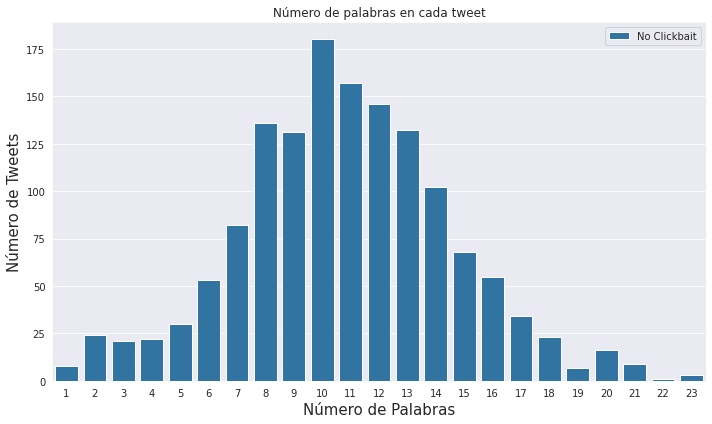

media de palabras : 10.808333333333334


In [55]:
# Primero voy a analizar los Clickbaits que fueron clasificados erroneamente como no clickbaits, es decir, los falsos negativos
errores_fn = data[(data['Clase'] != data['pred']) & (data['Clase'] == 0)]

print(' Hay en total {} falsos negativos'.format(len(errores_fn))) # esto también se vé en la matriz de confusión anterior

data['prob'].describe()

# si atendemos a las probabilidades que arroja el modelo parace que no arroja probabilidades muy extremas, todas entorno al 50 %
#siendo la menor del 0.48 y la mayor del 0.55. Lo que quizá indica que el modelo no tiene un gran poder discriminador

# Ahora voy a comprobar si el número de palabras es algo importante en los errores
errores_fn['num_palabras'] = errores_fn['postText'].apply(lambda x: len(x.split()))

#plot
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(errores_fn['num_palabras'],hue=errores_fn['Clase'],data=errores_fn)
plt.xlabel('Número de Palabras',size=15)
plt.ylabel('Número de Tweets', size=15)
plt.legend(title=None,labels=['No Clickbait','Clickbait'],loc='upper right')
plt.title('Número de palabras en cada tweet')
plt.tight_layout()
plt.show()


# Contar la media de palabras que tiene un tweet 
print('media de palabras : {}'.format(errores_fn['num_palabras'].mean()))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


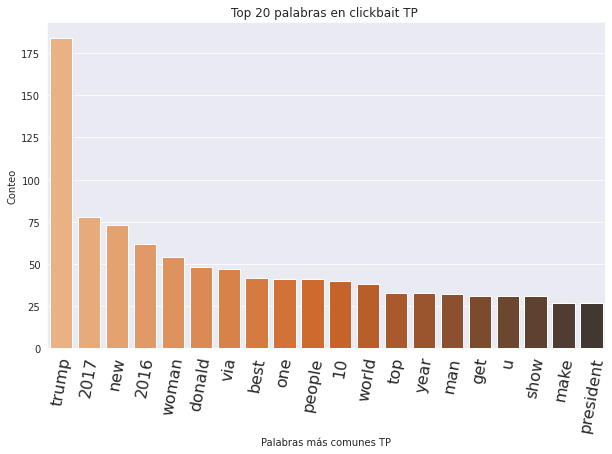

In [56]:


# parece que no ha influido, los falsos negativos tienen una media de palabras del 10.8 que está en la media de todo el dataset de clickbait.
#Si vemos ahora las palabras más comunes en estos tweets

errores_fn['texto_limpio'] = errores_fn['postText'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

cb_list=list(errores_fn['texto_limpio'])
cb_list = [wrd for sub in cb_list for wrd in sub.split()]


# El siguiente código es para sacar las frecuencias de las palabras
cb_freq = FreqDist(cb_list)


cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]


#plots con las 20 palabras más comunes en cada clase
#clickbait
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 palabras en clickbait fn ')
plt.xlabel('Palabras más comunes fn')
plt.ylabel('Conteo')
sns.set_style('darkgrid')
plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


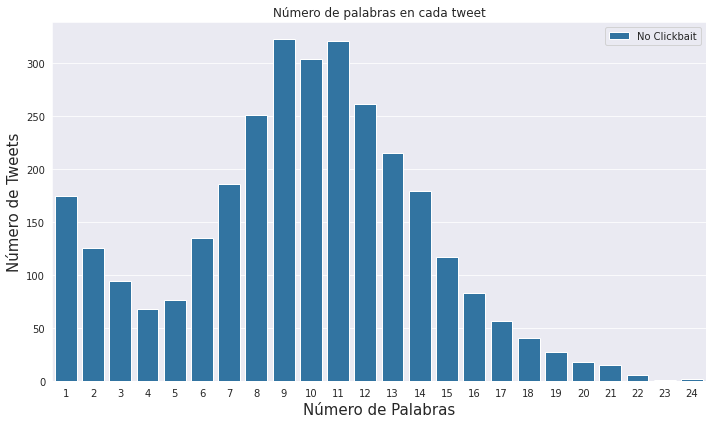

9.59479674796748

In [45]:
# Para ver si hay algo a destacar vamos a calcularlas para los True postive y comaprar

tp = data[(data['Clase'] == data['pred']) & (data['Clase'] == 0)]

tp['num_palabras'] = tp['postText'].apply(lambda x: len(x.split()))

#plot
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(tp['num_palabras'],hue=tp['Clase'],data=tp)
plt.xlabel('Número de Palabras',size=15)
plt.ylabel('Número de Tweets', size=15)
plt.legend(title=None,labels=['No Clickbait','Clickbait'],loc='upper right')
plt.title('Número de palabras en cada tweet')
plt.tight_layout()
plt.show()

# Contar la media de palabras que tiene un tweet 
print('media de palabras : {}'.format(tp['num_palabras'].mean()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


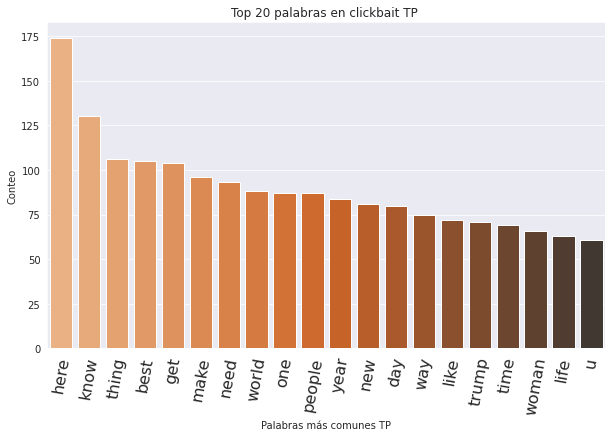

In [50]:
tp['texto_limpio'] = tp['postText'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

cb_list=list(tp['texto_limpio'])
cb_list = [wrd for sub in cb_list for wrd in sub.split()]


# El siguiente código es para sacar las frecuencias de las palabras
cb_freq = FreqDist(cb_list)


cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]


#plots con las 20 palabras más comunes en cada clase
#clickbait
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 palabras en clickbait TP ')
plt.xlabel('Palabras más comunes TP')
plt.ylabel('Conteo')
sns.set_style('darkgrid')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


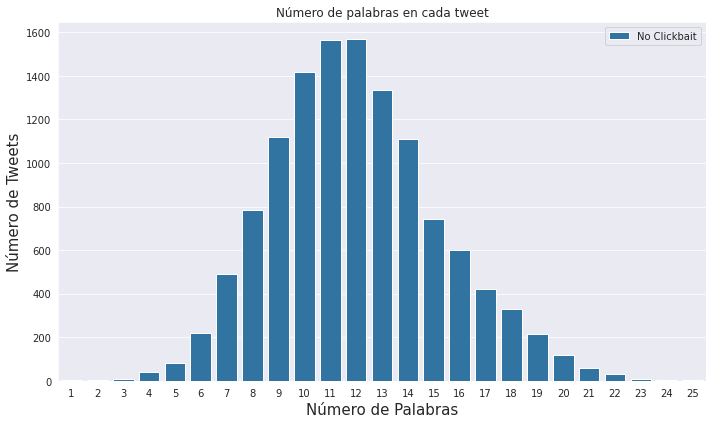

media de palabras : 12.001059322033898


In [57]:
# Comparando con los TP se puede ver que estos tienen un número de palabras menor de media
# esto le puede servir al modelo para diferencia mejor, así mismo hay palabras que pueden ser 
# típicas para un clickbait como "here" en referencia a un enlace, "thing","best","get"
# Por el contraio los FN la media de palabra es mayor y además destaca la palabra de trump que
# posiblemente como vimos al principio también este muy presente en los tweets con son no clickbait
# Además parece que tienen palabras muy comunes que pueden estar en tweets normales
# para comprobar este último punto vamos a ver las palabras más comunes para los TN es decir los que son de verdad no clickbait
# y que el modelo indentíficó correctamente

tn = data[(data['Clase'] == data['pred']) & (data['Clase'] == 1)]

tn['num_palabras'] = tn['postText'].apply(lambda x: len(x.split()))

#plot
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(tn['num_palabras'],hue=tn['Clase'],data=tn)
plt.xlabel('Número de Palabras',size=15)
plt.ylabel('Número de Tweets', size=15)
plt.legend(title=None,labels=['No Clickbait','Clickbait'],loc='upper right')
plt.title('Número de palabras en cada tweet')
plt.tight_layout()
plt.show()

# Contar la media de palabras que tiene un tweet 
print('media de palabras : {}'.format(tn['num_palabras'].mean()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


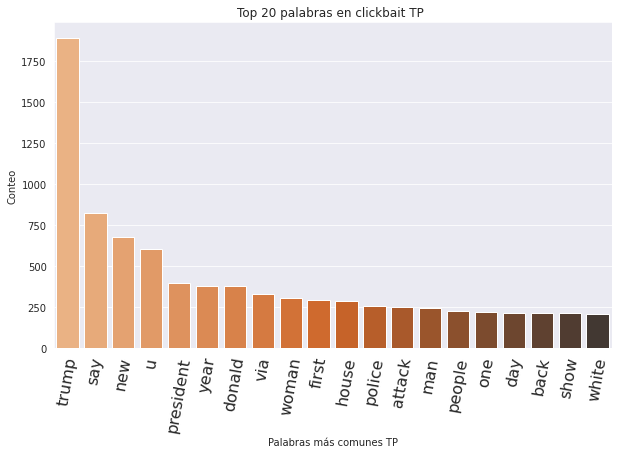

In [58]:
tn['texto_limpio'] = tn['postText'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

cb_list=list(tn['texto_limpio'])
cb_list = [wrd for sub in cb_list for wrd in sub.split()]


# El siguiente código es para sacar las frecuencias de las palabras
cb_freq = FreqDist(cb_list)


cb_bar_counts = [x[1] for x in cb_freq.most_common(20)]
cb_bar_words = [x[0] for x in cb_freq.most_common(20)]


#plots con las 20 palabras más comunes en cada clase
#clickbait
word_freq_figure1 = plt.figure(figsize=(10,6))
sns.barplot(cb_bar_words, cb_bar_counts,palette='Oranges_d')
plt.xticks(fontsize=16)
plt.xticks(rotation=80)
plt.title('Top 20 palabras en clickbait TN ')
plt.xlabel('Palabras más comunes TN')
plt.ylabel('Conteo')
sns.set_style('darkgrid')
plt.show()

Las gráficas de los tn confirman lo mencionado anteriormente, son tweets más largos y además tienen palabras en comun con los tweets que son fn, Sobretodo la palabras relacionadas con Trump y el ex presidente de EEUU. En este dataset Trump está muy presente como vimos al principio y aparece tanto en clickbaits como no clickbaits. El modelo tiene problemas para clasificar correctamente estos tweets que son clickbaits donde aparece trump o palabras relacionadas con el porque también aparece en en tweets no clickbait. 

Por el contrario los tweets con palabras caracteristicas de clickbait como "here" en referencia a un enlace, "thing","best" o "get", parece que los clasifica correctamente. Además el tamaño del tweet también pude ser un punto sobre el que tarbajar los tweets de clickbait que ha clasificado mal eran de media más largos que los que ha clasificado bien

# **Próximos pasos**

Para tener un conocimiento más profundo de cómo clasifica el modelo y que features son las más importantes una implementación de BERT que permita el uso de librerias como shap o lime sería lo ideal. Librerías como la de shap ayudan a través de técnicas de game theory a descubrir cuáles son las features más importantes.

Una vez analizado el punto anterior se puede intentar mejorar el modelo de transformer de muchas formas. La más evidente sería hacer un ajuste de los hiperparametros para hacerlos optimos, se puden usar herramientas como weight and biases o tenserboard para ver la performance del modelo durante el entrenamiento más en detalle. Este es un proceso iterativo. Además también se puede utilizar otras herramientas como keras que te encuentrar los parametros más optimos de una forma similar a como he utilizado el gridsearchcv. Incluso se podría utilizar algoritmos de optimización para encontar la mehor arquitectura pra la cabeza del modelo hay herramientas como Comet.ml que hacen esto.

Otro punto a abordar sería el desbalanceo del dataset. Hay diferentes formas de abordar esto, uan es la que he tomado yo que consiste en dalrle diferente peso  a las clases, pero hay otras que quizá den mejor resultado, como undersampling, oversamplin o utilizar datos sintéticos. Otra forma de abordar el problemas seria utilizar una loss diferente al binary crossentropy que penalice más los fallos en clases minoritarias, focal loss es usada para estos casos.

Finalmente, también se podríam usar modelos de Transformer más potentes como RoBERTa o XML, o incluso hacer un esemble con diferentes modelos de machine learning clásico como los que he desarrollado, para esto es importante que cada modelo sea bueno en una cosa diferente.